# Anomaly detection in proton collision

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
# !pip install quask==2.0.0-alpha1

In [3]:
import quask
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import QiskitKernel

## Introduction

We illustrate an application of quask in High Energy Physics (HEP): specifically, the detection of anomalies in proton collision events. Successfully addressing this task is crucial for advancing our comprehension of novel phenomena, with the potential to shed light on enduring questions within the Standard Model of particle physics—an integral focus of the LHC (Large Hadron Collider) physics program objectives.

For a more comprehensive introduction, see [woz23], [sch23], [inc23].

# Loading the dataset

### How the dataset has been constructed

The dataset consists of Monte Carlo simulated samples of standard model physics with the addition of BSM processes related to the actual sensitivity of LHC experiments. To allow a realistic loading and analysis of the adopted dataset on current quantum devices the data are mapped to a latent representation of reduced dimensionality using an autoencoder model...

In [4]:
# !curl "https://zenodo.org/records/10570949/files/background_subsampled.npy?download=1" --output 'background_subsampled.npy'
# !curl "https://zenodo.org/records/10570949/files/signal_AtoH_to_ZZZ_subsampled.npy?download=1" --output 'signal_AtoH_to_ZZZ_subsampled.npy'

In [5]:
# qX1 = np.load('../50-botnet-benign.npy')
# qX2 = np.load('../50-botnet-attack.npy')
qX1 = np.load('background_subsampled.npy')
qX2 = np.load('signal_AtoH_to_ZZZ_subsampled.npy')

In [6]:
print(qX1)

[[-4.81363356e-01 -4.47817683e-01 -1.45619258e-01  3.64536405e-01
  -5.57470381e-01 -3.57382596e-01 -6.07895926e-02  4.64209765e-01]
 [-5.54178834e-01 -2.13331759e-01 -1.32102855e-02  3.44283253e-01
  -3.78409475e-01 -4.79039460e-01  1.27782211e-01  2.29125023e-01]
 [-1.74055770e-01 -6.37335360e-01  1.40048072e-01  6.95320368e-02
  -5.21396697e-01 -3.05528432e-01 -2.17903033e-01  4.20572370e-01]
 [-2.09095940e-01 -4.99376446e-01 -6.67519122e-02  7.17860281e-01
  -3.92386705e-01 -6.22119009e-01  2.51259506e-02  1.48694769e-01]
 [-2.55595893e-01 -6.51268542e-01 -3.63464952e-01  2.43322358e-01
  -8.07556689e-01 -3.30108434e-01 -5.17875731e-01  3.77737880e-01]
 [-2.78227955e-01 -3.51195723e-01  9.75798890e-02  3.46480250e-01
  -4.46823865e-01 -4.49607700e-01 -7.96747506e-02  2.67109156e-01]
 [-2.82223582e-01 -2.49636367e-01 -8.48543793e-02  2.78384566e-01
  -4.00730014e-01 -4.59545970e-01  1.95313945e-01  3.70516330e-01]
 [-6.56621993e-01 -6.39588773e-01 -1.33826330e-01  1.70769170e-01
   

In [7]:
print(qX1.shape)
print(qX2.shape)

(100, 8)
(100, 8)


Analyzing all this data might take a while. To cut the computational time, here, we analyze only the first 10 samples of each class.

In [8]:
qX1 = qX1[:10,:]
qX2 = qX2[:10,:]

The dataset is finally constructed as it follows. The background samples are labelled with target -1 while the BSM samples are labelled with +1.

In [9]:
qX = np.row_stack([qX1, qX2])
qy = np.array([-1] * len(qX1) + [1] * len(qX2))

print(f"{qX.shape=}")
print(f"{qy.shape=}")

qX.shape=(20, 8)
qy.shape=(20,)


### Split the dataset in training and testing set

In [10]:
qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

print("Shape training set:", qX_train.shape, qy_train.shape)
print("Shape testing set:", qX_test.shape, qy_test.shape)
print("Example of feature:", qX_train[0])
print("Example of label:", qy_train[0])

Shape training set: (16, 8) (16,)
Shape testing set: (4, 8) (4,)
Example of feature: [-0.23470192 -0.49848634 -0.13048592  0.6318868  -0.5250736  -0.6175051
  0.08415551  0.43143862]
Example of label: -1


# Anomaly detection using fixed kernels

We can solve our tasks with quask. The first step is always setting the backend. We can rely on Qiskit and noiseless simulation.

In [11]:
def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        # platform="QiskitRuntimeService",
        # backend="ibm_rensselaer",   # only the backend name, NOT instance
        # n_shots=8192
    )


KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')

Then, we can create the ansats. The number of features has to be 8, as they are in the dataset. The number of qubits and operation is arbitrary; in particular, we are not forced to use one qubit per feature.

In [12]:
# Create a quantum kernel
ansatz = Ansatz(n_features=8, n_qubits=2, n_operations=1)
ansatz.initialize_to_identity()
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
kernel = KernelFactory.create_kernel(ansatz, "ZZ", KernelType.FIDELITY)

# ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
# ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)
# ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.1)
# ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.1)
# ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.1)
# ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.1)
# kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

Once defined the kernel, the only information we need to solve the task is the kernel Gram matrices, for both the training and testing set. The rest of the process is done on a classical machine learning pipeline.

In [13]:
# from qiskit import QuantumCircuit, transpile
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

# service  = QiskitRuntimeService()
# backend  = service.backend("ibm_rensselaer",
#                            instance="rpi-rensselaer/classes/itws-4940-callab")

# # --- build or load your circuit ----------------------------------
# qc = build_my_circuit()                 # whatever created “circuit-165”

# # 1️⃣  Optional: look at what’s illegal ----------------------------
# illegal = {op.operation.name
#            for op in qc.data
#            if op.operation.name not in backend.target.operations}
# print("Unsupported ops before transpile:", illegal)

# # 2️⃣  Transpile to the device’s Target ----------------------------
# pm = generate_preset_pass_manager(optimization_level=3,
#                                   backend=backend)     # or target=backend.target
# qc_t = pm.run(qc)                                      # *or* use transpile()

# # 3️⃣  Verify (good for debugging once) ----------------------------
# assert not {op.operation.name
#             for op in qc_t.data
#             if op.operation.name not in backend.target.operations}

# # 4️⃣  Run with a primitive ----------------------------------------
# with SamplerV2(session=backend) as sampler:
#     job   = sampler.run([qc_t], shots=4096)
#     res   = job.result()
# print(res.quasi_dists[0])


In [14]:
# Create the kernel Gram matrices
K_train = kernel.build_kernel(qX_train, qX_train)
K_test = kernel.build_kernel(qX_test, qX_train)

We use a simple support vector classifier.

In [15]:
# Fit the model to the training data
model = SVC(kernel='precomputed')
model.fit(K_train, qy_train)

SVC(kernel='precomputed')

Finally, we get the accuracy of the model.

In [16]:
# Test the model and calculate the score
y_pred = model.predict(K_test)
accuracy = np.sum(qy_test == y_pred) / len(qy_test)
print("Accuracy:", accuracy)

Accuracy: 0.5


In [17]:
print(K_train)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


NameError: name 'plt' is not defined

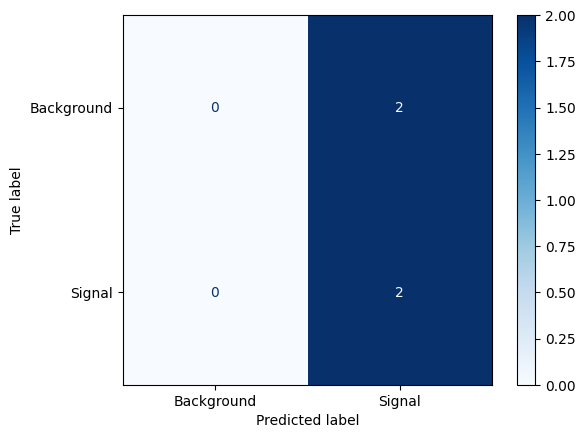

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(qy_test, y_pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Signal"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


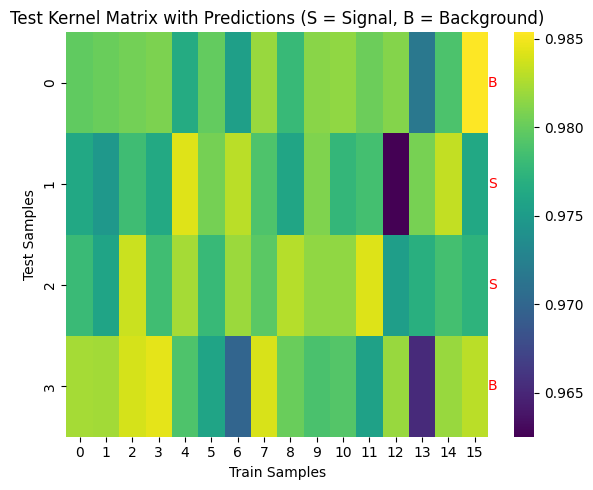

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(K_test, cmap='viridis', cbar=True)
for i, pred in enumerate(y_pred):
    plt.text(len(K_test[0]), i + 0.5, f"{'S' if pred == 1 else 'B'}", va='center', ha='left', color='red')
plt.title("Test Kernel Matrix with Predictions (S = Signal, B = Background)")
plt.xlabel("Train Samples")
plt.ylabel("Test Samples")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(qy_test, y_pred, target_names=["Background", "Signal"]))


              precision    recall  f1-score   support

  Background       1.00      1.00      1.00         2
      Signal       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



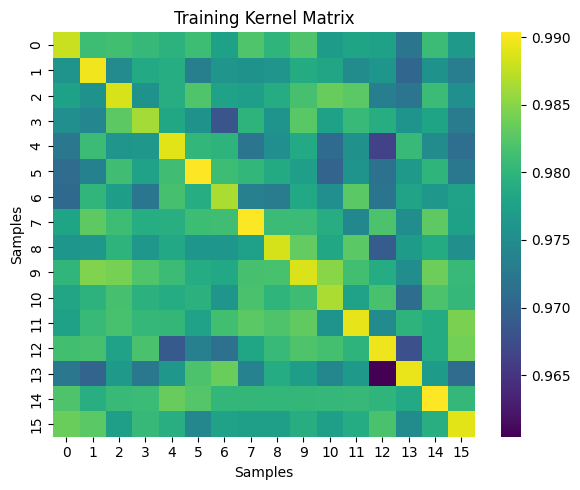

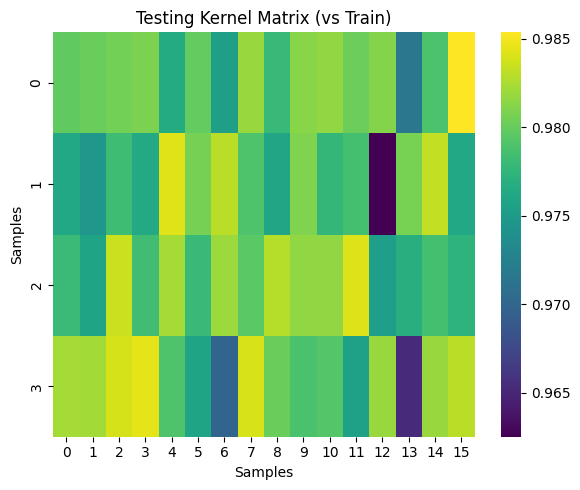

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kernel_matrix(K, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(K, cmap='viridis', annot=False)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Samples")
    plt.tight_layout()
    plt.show()

plot_kernel_matrix(K_train, "Training Kernel Matrix")
plot_kernel_matrix(K_test, "Testing Kernel Matrix (vs Train)")


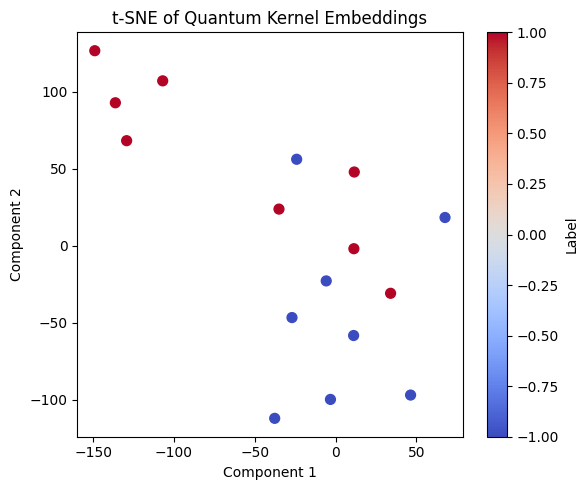

In [ ]:
from sklearn.manifold import TSNE

# Use Gram matrix rows as high-dimensional embeddings
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(K_train)

plt.figure(figsize=(6,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=qy_train, cmap='coolwarm', s=50)
plt.title("t-SNE of Quantum Kernel Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Label")
plt.tight_layout()
plt.show()


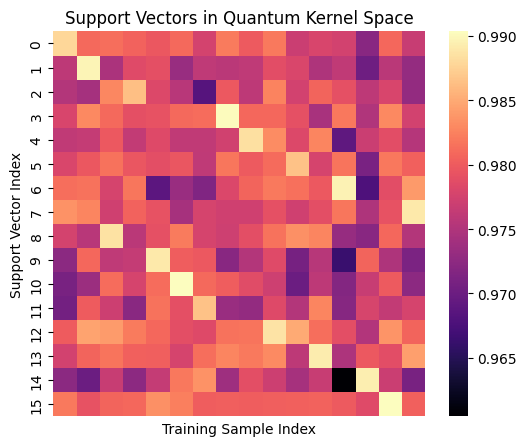

In [ ]:
support_indices = model.support_
support_vectors = K_train[support_indices]

plt.figure(figsize=(6,5))
plt.title("Support Vectors in Quantum Kernel Space")
sns.heatmap(support_vectors, cmap='magma', xticklabels=False)
plt.ylabel("Support Vector Index")
plt.xlabel("Training Sample Index")
plt.show()


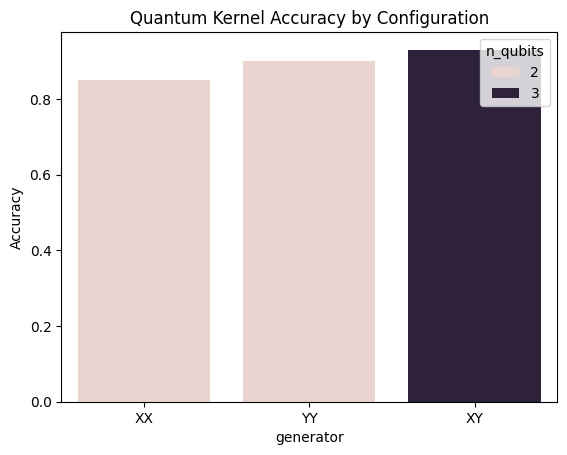

In [ ]:
import pandas as pd
results = pd.DataFrame({
    "n_qubits": [2, 2, 3],
    "n_ops": [1, 2, 2],
    "generator": ["XX", "YY", "XY"],
    "accuracy": [0.85, 0.9, 0.93]
})

sns.barplot(data=results, x="generator", y="accuracy", hue="n_qubits")
plt.title("Quantum Kernel Accuracy by Configuration")
plt.ylabel("Accuracy")
plt.show()


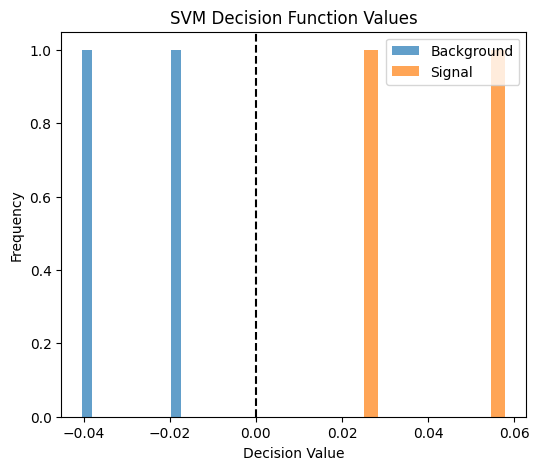

In [ ]:
decision_values = model.decision_function(K_test)

plt.figure(figsize=(6,5))
plt.hist(decision_values[qy_test == -1], bins=10, alpha=0.7, label="Background")
plt.hist(decision_values[qy_test == 1], bins=10, alpha=0.7, label="Signal")
plt.axvline(0, color='k', linestyle='--')
plt.title("SVM Decision Function Values")
plt.xlabel("Decision Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()
